# Decoding Musical Genre from fMRI Brain Activity

A straightforward walkthrough where I learn how to explore and analyze fMRI data collected while listening to different music genres.

Dataset: fMRI brain activity (22,036 features per sample)

This notebook is based on the paper:

> **Classifying The Brain on Music**  
> *Michael Casey et al., 2017*  
> *Frontiers in Psychology, Vol. 8, Article 1179*  
> [Read the full paper](https://www.frontiersin.org/journals/psychology/articles/10.3389/fpsyg.2017.01179/full)

The dataset was used in the Kaggle competition:

> **[Classifying the Brain on Music](https://www.kaggle.com/competitions/classifying-the-brain-on-music)**

The goal is to understand how to work with brain data and perform simple analysis.

In [5]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning tools
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings('ignore')

### 🧩 Imports Overview

| Library | Purpose |
|----------|----------|
| **pandas** | Reading and exploring tabular data |
| **numpy** | Fast math and array manipulation |
| **matplotlib / seaborn** | Visualizations |
| **scikit-learn** | ML preprocessing, models, evaluation |

In [6]:
# Load the dataset

!pip install gdown # This download code was included in the original Google Colab file
!gdown --id 1aFDPryEDcT5wg0k8NhWYpF8lulGmot5J # train data
!gdown --id 11kgAdB_hkEcC4npCEWJcAOOmGe3495yY # train labels
!gdown --id 1wXq56F6RIUtDzPceZegZAMA-JGW21Gqu # test data

train_data = pd.read_csv('train_data.csv', header=None)
train_labels = pd.read_csv('train_labels.csv', header=None)
test_data = pd.read_csv('test_data.csv', header=None)

X_train = train_data.values
y_train = train_labels.values.ravel()
X_test = test_data.values

print('Training data shape:', X_train.shape)
print('Test data shape:', X_test.shape)
print('Labels shape:', y_train.shape)

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1aFDPryEDcT5wg0k8NhWYpF8lulGmot5J
To: /content/train_data.csv
100% 89.7M/89.7M [00:00<00:00, 152MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=11kgAdB_hkEcC4npCEWJcAOOmGe3495yY
To: /content/train_labels.csv
100% 320/320 [00:00<00:00, 1.17MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://d

Each row represents a 6-second brain scan sample, and each column represents activity from a specific brain region. There are 22,036 features in total.

`ravel()` flattens the labels into a 1D array so scikit-learn models can read them properly.

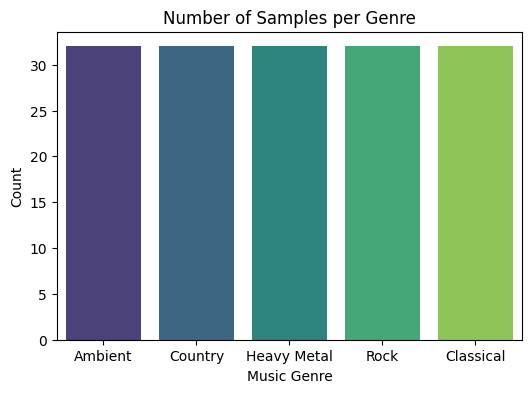

In [7]:
# Explore genre balance
unique, counts = np.unique(y_train, return_counts=True)
genres = ['Ambient', 'Country', 'Heavy Metal', 'Rock', 'Classical']

plt.figure(figsize=(6,4))
sns.barplot(x=genres, y=counts, palette='viridis')
plt.title('Number of Samples per Genre')
plt.xlabel('Music Genre')
plt.ylabel('Count')
plt.show()

The genres appear balanced. No one single genre dominates the dataset.

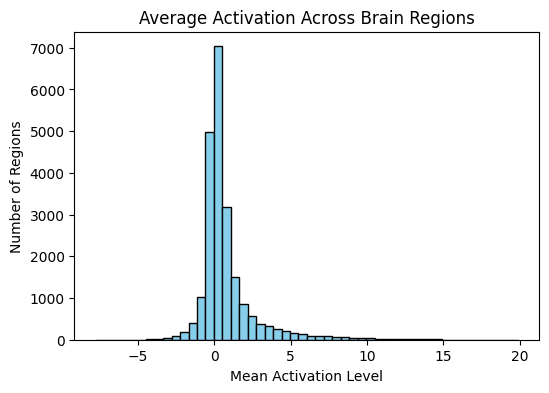

In [8]:
# Check mean brain activation distribution
plt.figure(figsize=(6,4))
plt.hist(X_train.mean(axis=0), bins=50, color='skyblue', edgecolor='black')
plt.title('Average Activation Across Brain Regions')
plt.xlabel('Mean Activation Level')
plt.ylabel('Number of Regions')
plt.show()

This quick histogram shows how brain activation values vary across all 22,036 regions.

In [9]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

print('After scaling, each feature has mean 0 and standard deviation 1.')

After scaling, each feature has mean 0 and standard deviation 1.


Standardization makes all brain regions comparable so no single feature dominates due to larger numeric range.

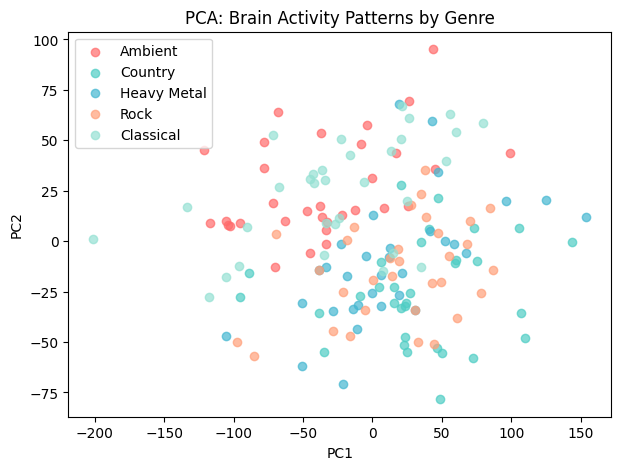

In [10]:
# Apply PCA for visualization (2 components)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#95E1D3']
plt.figure(figsize=(7,5))
for i, color in enumerate(colors):
    mask = y_train == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], color=color, label=genres[i], alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: Brain Activity Patterns by Genre')
plt.legend()
plt.show()

The PCA plot provides a simplified 2D view of high-dimensional brain activity. Clusters suggest genres that may have distinct neural signatures.

In [11]:
# Train a simple Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_scaled, y_train)

scores = cross_val_score(model, X_scaled, y_train, cv=5, scoring='accuracy')
print('Cross-validation accuracy (average):', round(scores.mean(), 3))

Cross-validation accuracy (average): 0.675


Cross-validation gives a more reliable accuracy estimate than a single train/test split.

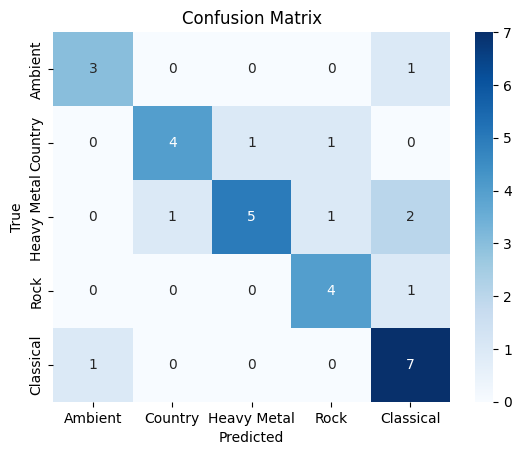

              precision    recall  f1-score   support

     Ambient       0.75      0.75      0.75         4
     Country       0.80      0.67      0.73         6
 Heavy Metal       0.83      0.56      0.67         9
        Rock       0.67      0.80      0.73         5
   Classical       0.64      0.88      0.74         8

    accuracy                           0.72        32
   macro avg       0.74      0.73      0.72        32
weighted avg       0.74      0.72      0.72        32



In [12]:
# Confusion matrix visualization
X_train_split, X_val, y_train_split, y_val = train_test_split(X_scaled, y_train, test_size=0.2, random_state=42)
model.fit(X_train_split, y_train_split)
y_pred = model.predict(X_val)

cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=genres, yticklabels=genres)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(classification_report(y_val, y_pred, target_names=genres))

The confusion matrix shows which genres the model predicts correctly vs. where it struggles.

Diagonal = correct predictions.
Off-diagonal = misclassifications.

# Wrapping Up

- Learned how to load and explore fMRI data.
- Understood the importance of scaling and dimensionality reduction.
- Visualized brain activity using PCA.
- Applied and evaluated a simple ML model.